In [2]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

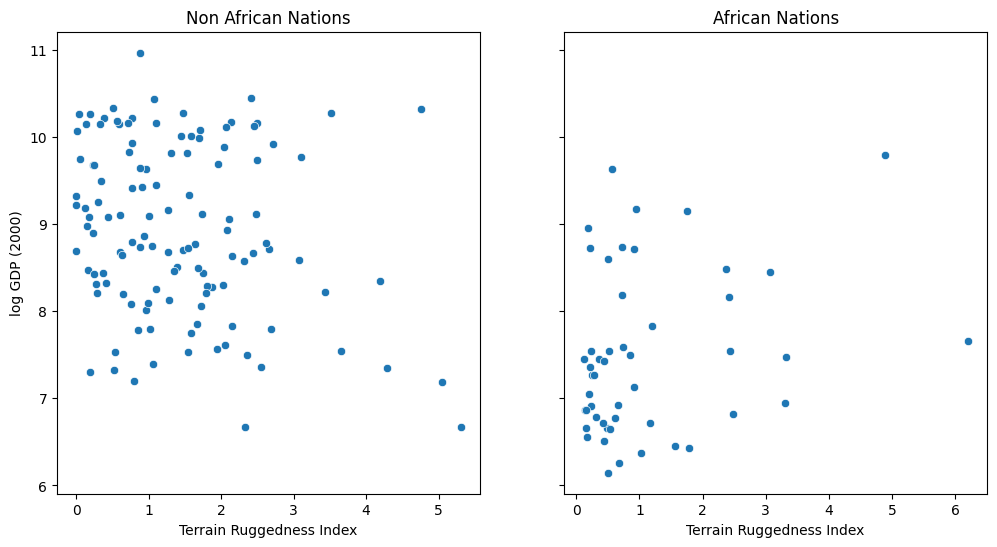

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [6]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [7]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7847
[iteration 0100] loss: 1616.1367
[iteration 0150] loss: 1109.4114
[iteration 0200] loss: 833.7542
[iteration 0250] loss: 637.5819
[iteration 0300] loss: 488.2649
[iteration 0350] loss: 376.4648
[iteration 0400] loss: 296.0481
[iteration 0450] loss: 240.6138
[iteration 0500] loss: 203.9385
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3493
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

In [8]:
linear_reg_model

PyroLinear(in_features=3, out_features=1, bias=True)

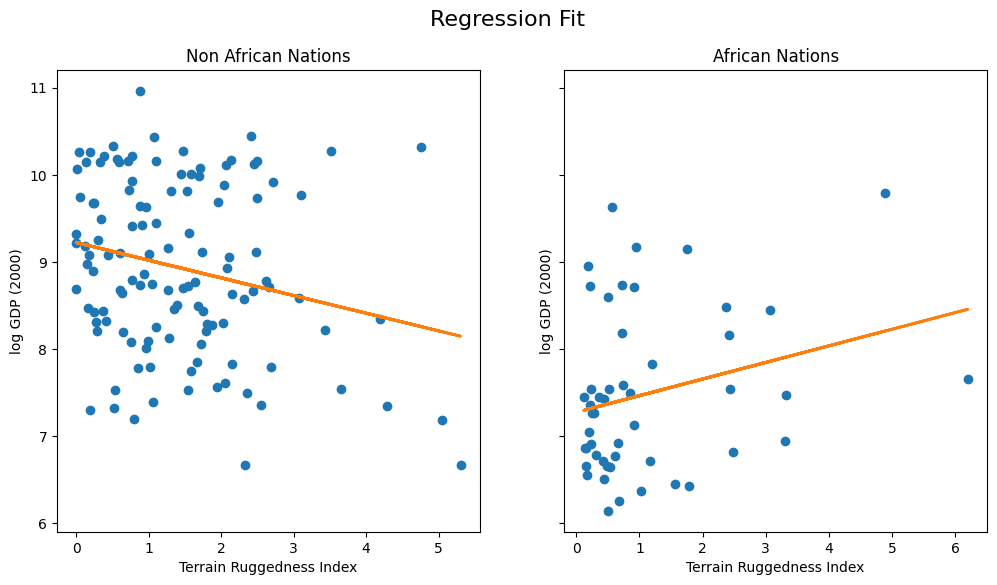

In [9]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [12]:
linear_reg_model, list(linear_reg_model.named_parameters())

(PyroLinear(in_features=3, out_features=1, bias=True),
 [('weight',
   Parameter containing:
   tensor([[-1.9479, -0.2028,  0.3933]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([9.2231], requires_grad=True))])

In [171]:
import scanpy as sc
adata_train = sc.read_h5ad('./.cache/adata_train.h5ad')

In [173]:
import sys
sys.path.append('../src')
from spaceoracle.tools.network import DayThreeRegulatoryNetwork

In [174]:
grn = DayThreeRegulatoryNetwork()

In [250]:
regulators = grn.get_regulators(adata_train, 'Cd74')

In [251]:
y = adata_train.to_df(layer='imputed_count')['Cd74'].values
X = adata_train.to_df(layer='imputed_count')[regulators].values

In [8]:
import pyro.infer
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.nn import PyroSample
from torch import nn
from pyro.nn import PyroModule

In [47]:
class BayesianLinear(PyroModule):
    def __init__(self, in_size, out_size):
       super().__init__()
       self.bias = PyroSample(
           prior=dist.LogNormal(0, 1).expand([out_size]).to_event(1))
       self.weight = PyroSample(
           prior=dist.Normal(0, 1).expand([in_size, out_size]).to_event(2))

    def forward(self, input):
        return self.bias + input @ self.weight  # this line samples bias and weight

In [236]:
class Model(PyroModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear = BayesianLinear(in_size, out_size+1)  # this is a PyroModule
        self.obs_scale = PyroSample(dist.LogNormal(0, 1))
        self.beta_dim = out_size

    def forward(self, input, inputs_x, y=None):
        obs_loc = self.linear(input)  # this samples linear.bias and linear.weight
        obs_scale = self.obs_scale    # this samples self.obs_scale

        y_pred = obs_loc[:, 0]
        for w in range(self.beta_dim):
            y_pred += obs_loc[:, w+1]*inputs_x[:, w]

        y_pred = y_pred.unsqueeze(-1)

        with pyro.plate("instances", len(input)):
            return pyro.sample("obs", dist.Normal(y_pred, obs_scale).to_event(1),
                               obs=y).view(-1)
            

In [229]:
model = Model(128, 45)
model.forward(
    torch.randn(512, 128), 
    torch.randn(512, 45), 
    y=torch.randn(512)
).shape

y_pred torch.Size([512, 1])


torch.Size([512])

In [230]:
model = Model(128, 45)
model.forward(
    torch.randn(512, 128), 
    torch.randn(512, 45), 
    y=None
).shape

y_pred torch.Size([512, 1])


torch.Size([512])

In [220]:
Regression(128, 1).forward(
    torch.randn(512, 128), 
    y=torch.randn(512)
).shape

mean torch.Size([512])


torch.Size([512])

In [135]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Assuming input size is 28x28
        self.fc2 = nn.Linear(64, out_features)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage:



In [123]:
cnn = SimpleCNN(in_channels=7, out_features=128)
model = Model(128, 45)

In [147]:
class BetaMaker(nn.Module):
    def __init__(self, in_channels=7, out_features=128, beta_dim=45):
        super().__init__()
        self.beta_dim = beta_dim
        self.cnn = SimpleCNN(in_channels=in_channels, out_features=out_features)
        self.model = Model(out_features, beta_dim+1)

    def forward(self, x, inputs_x):
        betas = self.model(self.cnn(x))

        y_pred = betas[:, 0]
        for w in range(self.beta_dim):
            y_pred += betas[:, w+1]*inputs_x[:, w]

        return y_pred

In [151]:
img = torch.randn(5, 7, 28, 28)
input_x = torch.randn(5, 45)

In [153]:
BetaMaker().forward(img, input_x).detach().cpu().numpy()

array([-24.81972  ,  -9.8563175, -16.36133  ,   9.325987 , -35.301434 ],
      dtype=float32)

In [154]:
BetaMaker().forward(img, input_x).detach().cpu().numpy()

array([  1.0876151, -33.439545 ,  -1.8086355,  10.165192 , -27.584604 ],
      dtype=float32)

<Axes: ylabel='Density'>

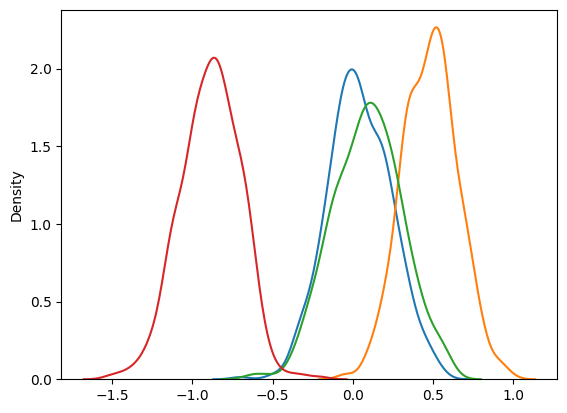

In [125]:
sns.kdeplot(model.forward(cnn.forward(img_batch))[:, 0].detach().cpu().numpy())
sns.kdeplot(model.forward(cnn.forward(img_batch))[:, 0].detach().cpu().numpy())
sns.kdeplot(model.forward(cnn.forward(img_batch))[:, 0].detach().cpu().numpy())
sns.kdeplot(model.forward(cnn.forward(img_batch))[:, 0].detach().cpu().numpy())


In [237]:
from pyro.infer.autoguide import AutoNormal
model = Model(128, 45)
guide = AutoNormal(model)
pyro.clear_param_store()
pyro.set_rng_seed(1)

x = torch.randn(512, 128)
inputs_x = torch.randn(512, 45)
y = torch.randn(512, 1)
svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())

In [239]:
model.forward(x, inputs_x, y=y).shape

torch.Size([512])

In [240]:
svi.step(x, inputs_x, y)

46989.784854754806

In [243]:
for step in range(10):
    loss = svi.step(x, inputs_x, y) / y.numel()
    print("step {} loss = {:0.4g}".format(step, loss))

step 0 loss = 34.01
step 1 loss = 36.38
step 2 loss = 34.16
step 3 loss = 34.69
step 4 loss = 35.14
step 5 loss = 36.23
step 6 loss = 31.29
step 7 loss = 31.07
step 8 loss = 36.03
step 9 loss = 31.48


In [46]:
model.forward(torch.randn(512, 7, 28, 28)).shape

torch.Size([512, 1])

<Axes: ylabel='Density'>

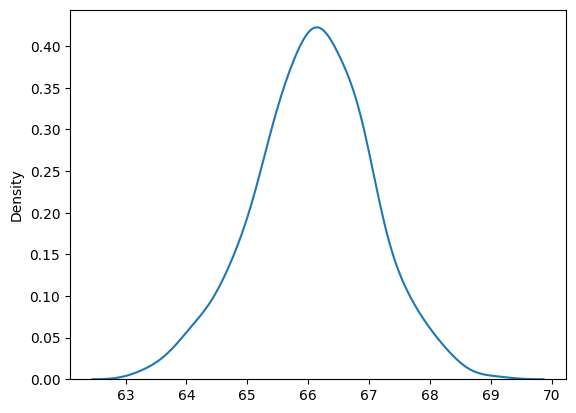

In [41]:
sns.kdeplot(pyro.sample("betas", dist.Normal(torch.ones(512, 45)*66, 1.))[:, 10].detach().cpu().numpy())


<Axes: ylabel='Density'>

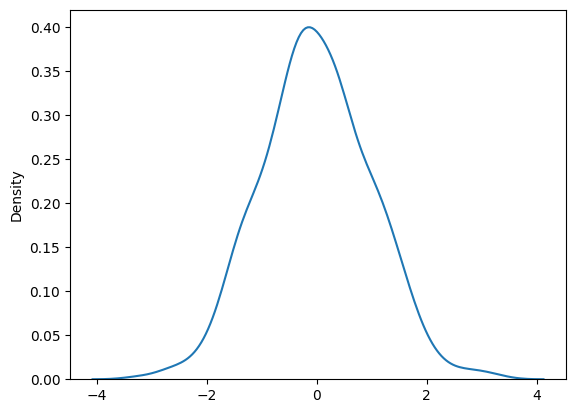

In [40]:
sns.kdeplot(pyro.sample("betas", dist.Normal(torch.zeros(512, 45)*66, 1.))[:, 10].detach().cpu().numpy())


In [386]:
nn.Linear(45, 1).forward(torch.randn(512, 45)).shape

torch.Size([512, 1])

In [388]:
nn.Linear(45, 1).weight.shape, CustomLinear(45).weight.shape

(torch.Size([1, 45]), torch.Size([45]))

In [368]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        print('!', x.shape, mean.shape, sigma.shape, x.shape[0])
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [354]:
from pyro.infer.autoguide import AutoDiagonalNormal


In [355]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_35729/2540352491.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_35729/2540352491.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float)


In [356]:
X.shape, y.shape

(torch.Size([10277, 45]), torch.Size([10277]))

In [357]:
x_data.shape, y_data.shape

(torch.Size([100, 14]), torch.Size([100]))

In [369]:
from pyro.infer import SVI, Trace_ELBO

model = BayesianRegression(len(regulators), 1)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [359]:
mask = adata_train.obs.rctd_cluster==0

In [370]:
X[mask].shape, y[mask].shape, len(regulators)

(torch.Size([6604, 45]), torch.Size([6604]), 45)

In [371]:
svi.step(X[mask], y[mask])


! torch.Size([6604, 45]) torch.Size([6604]) torch.Size([]) 6604
! torch.Size([6604, 45]) torch.Size([6604]) torch.Size([]) 6604


21511.12210714817

In [360]:
pyro.clear_param_store()
for j in range(1000):
    # calculate the loss and take a gradient step
    loss = svi.step(X[mask], y[mask])
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

TypeError: forward() takes 2 positional arguments but 3 were given

In [327]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X)
pred_summary = summary(samples)

In [375]:
samples['_RETURN']['mean'].shape

IndexError: too many indices for tensor of dimension 2

In [339]:
mu = pred_summary["_RETURN"]
y_dict = pred_summary["obs"]
# predictions = pd.DataFrame({
#     "cont_africa": x_data[:, 0],
#     "rugged": x_data[:, 1],
#     "mu_mean": mu["mean"],
#     "mu_perc_5": mu["5%"],
#     "mu_perc_95": mu["95%"],
#     "y_mean": y["mean"],
#     "y_perc_5": y["5%"],
#     "y_perc_95": y["95%"],
#     "true_gdp": y_data,
# })

In [340]:
mu['mean'].mean()

tensor(0.3680)

In [329]:
mu['mean'].mean()

tensor(0.3680)

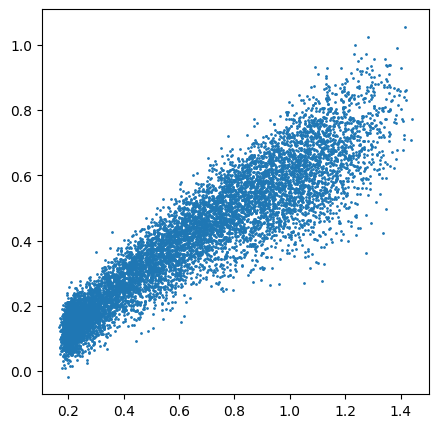

In [341]:
plt.scatter(y=mu['mean'], x=y, s=1)

In [300]:
.shape

torch.Size([6604, 45])

In [306]:
list(regulators).index('Pax5')

26

In [308]:
predictive(X[adata_train.obs.rctd_cluster==0])['linear.weight'].squeeze(1).squeeze(1).mean(0)[26]

tensor(0.9691)

In [310]:
predictive(X[adata_train.obs.rctd_cluster==5])['linear.weight'].squeeze(1).squeeze(1).mean(0)[26]

tensor(0.9693)

In [290]:
mu['mean'][adata_train.obs.rctd_cluster==0].mean()

tensor(0.7935)

In [291]:
mu['mean'][adata_train.obs.rctd_cluster==1].mean()

tensor(0.2701)

In [296]:
betas = samples['linear.weight'].reshape(800, len(regulators))
betas.shape

torch.Size([800, 45])

In [297]:
mu

{'mean': tensor([0.9929, 0.7654, 0.7077,  ..., 0.2018, 0.5265, 0.8112]),
 'std': tensor([0.0047, 0.0047, 0.0046,  ..., 0.0046, 0.0047, 0.0047]),
 '5%': tensor([0.9851, 0.7577, 0.7000,  ..., 0.1940, 0.5183, 0.8033]),
 '95%': tensor([1.0003, 0.7729, 0.7149,  ..., 0.2093, 0.5341, 0.8186])}

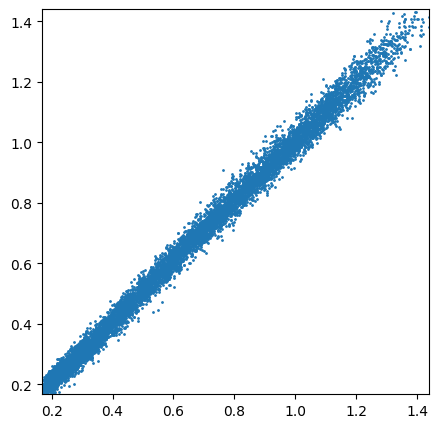

In [262]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(y=y_dict['mean'], x=y, s=1)
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.show()

In [272]:
y.shape, y_dict['mean'].shape

(torch.Size([10277]), torch.Size([10277]))

In [263]:
weight = samples["linear.weight"]
weight = weight.squeeze(1).squeeze(1)

In [269]:
df = pd.DataFrame(weight.detach().cpu().numpy(), columns=regulators)

In [271]:
df.mean()['Pax5']

0.96941733

In [245]:
weight.mean(0)

tensor([-5.5511e-04,  1.2556e+00,  5.4131e-01, -5.1380e-01,  4.6657e-01,
         1.0079e+00,  6.6863e-01,  7.6891e-01,  7.3138e-01,  3.7622e+00,
         1.5499e+00,  4.1345e-01,  4.6455e-01,  1.0398e+00, -3.9549e-02,
         4.0683e-01,  6.1659e-01,  1.5020e+00,  4.6749e-01,  9.3817e-01,
        -1.2736e+00, -3.5161e-01,  4.6562e+00,  2.1432e-01,  6.9058e-01,
         1.2008e+00,  1.4332e+00,  4.5812e-01,  7.4512e-01,  4.0333e-01,
         8.4146e-01,  5.4620e+00,  3.9640e-01,  1.4324e+00,  1.1562e+00,
        -6.8050e-01,  1.6443e+00,  3.7516e-01, -7.0623e-01,  2.3280e-01,
         6.2320e-01,  2.3090e-01,  3.7458e-01,  1.8724e+00, -2.3901e+00,
         9.0171e-01, -1.1532e+00,  1.3613e+00, -4.4693e-02,  1.0656e+00,
         2.6108e-01,  1.3443e-01,  6.3876e-01, -1.5035e+00,  1.0359e+00,
         1.1582e+00,  7.0202e-01,  5.0526e-01, -1.4670e+00,  1.4123e-01,
         1.0861e+00,  8.2847e-01,  7.9229e-01, -2.9632e-01,  3.2772e-01,
         8.4134e-01,  9.9657e-01,  1.4127e-01, -4.6

<Axes: ylabel='Count'>

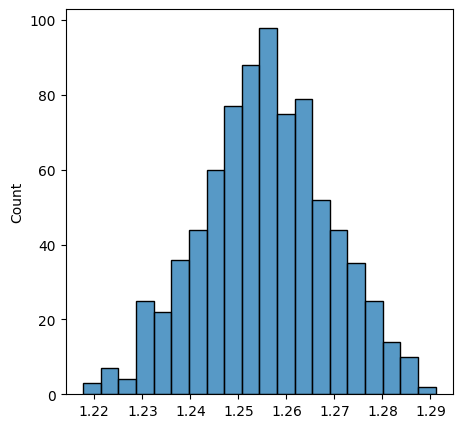

In [243]:
# sns.histplot(weight[:, 0].detach().cpu().numpy())
sns.histplot(weight[:, 1].detach().cpu().numpy())
# sns.histplot(weight[:, 2].detach().cpu().numpy())
# sns.histplot(weight[:, 3].detach().cpu().numpy())
# sns.histplot(weight[:, 4].detach().cpu().numpy())

